In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from astropy.time import Time
from scipy.interpolate import interp1d
import math
import copy
import glob
import subprocess
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

In [33]:
# Some routines to get the date of the first valid row of each file

def get_date_from_meteo_file(filename):
    df = pd.read_csv(filename, header=1, parse_dates={'Date':['YYYY/MM/JJ',' hh:mn:sec(HL)']})
    # date of first valid row
    dd = df['Date'][0].date()
    return (dd)

def read_single_meteo_file(filename,keep=['Date', 'pressure', 'Temperature', 'Humidity', 'windSpeed', 'windDir'],set_index=True):
    
    count = len(open(filename).readlines(  ))
    if count > 4:
        df = pd.read_csv(filename, header=1, parse_dates={'Date':['YYYY/MM/JJ',' hh:mn:sec(HL)']})
        # Remove spaces in column names
        df.rename(str.strip,axis='columns',inplace=True)
        # Rename some columns
        df.rename(columns={"outTemp": "Temperature", "outHumidity": "Humidity"},inplace=True)
        if (keep != 'all'):
            columns=keep
            index_to_remove = df.columns.drop(keep)
            df = df.drop(columns=index_to_remove)
        if (set_index):
            # Use Date as index
            df.set_index('Date',inplace=True)
    else:
        df = pd.DataFrame()
    return (df)

# Routine to prepare training samples from single contiguous dataframe
def split_series(series, n_past, n_future, out_column_index=5):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations 
    #
    out_column_index
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, [out_column_index]]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)  


# Routine to fill missing values with random values from data distribution
def fill_missing_values(dataframe,random=False):

    if (random):
        columns = dataframe.columns
        for col in columns:
            mean = dataframe[col].mean()
            std  = dataframe[col].std() 
            mask_nans = dataframe[col].isnull().values
            randoms = np.random.standard_normal(mask_nans.sum())*std + mean
            dataframe.loc[mask_nans,col]=randoms
    else:
        dataframe.interpolate(method='spline',order=3,inplace=True)
    return(dataframe)


In [34]:
def simple_data_preparation(data_dir = '/Users/cgiordano/Documents/Travail/WRF/Calern_ML/Data', 
                     meteo_dir='CATS',meteo_tag='meteo_cats_*.csv',
                     sampling_rate_min=5,interpolate=True):

    sampling_rate_str = '%dmin'%sampling_rate_min

   
    METEO_files = np.array(glob.glob(data_dir+'/'+meteo_dir+'/'+meteo_tag))
    filetest = np.array(['-'.join(item.split('_')[-1].split('.')[0].split('-')[::-1]) for item in METEO_files])
    idx = np.argsort(filetest)
    METEO_files = [item for item in METEO_files[idx]]
    nMETEO = len(METEO_files)


    framelist = []
    for file in METEO_files:
        print("Processing file %s"%file)
        df = read_single_meteo_file(file)
        if (df.empty):
            continue
        df = df.resample(sampling_rate_str).bfill()
        if (interpolate):
            df.interpolate('spline',order=1,inplace=True)
        framelist.append(df)
    meteo_data = pd.concat(framelist)
    
    
    # Add group index, based on time jumps bigger than 300s (this needs to be in sync with sampling_rate !!)
    meteo_data['groups'] = (meteo_data.index.to_series().diff().dt.seconds > 300).cumsum()
    return meteo_data


In [35]:
meteo_data = simple_data_preparation(data_dir = r'C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1', 
                     meteo_dir='CATS',meteo_tag='meteo_cats_*.csv',
                     sampling_rate_min=5,interpolate=True)

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-01-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-01-2015.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-04-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-04-2015.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-07-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-07-2015.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-10-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-10-2015.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_29-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_30-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_31-12-2015.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-01-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-01-2016.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_23-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_24-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_25-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_27-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_28-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_29-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_30-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_31-03-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-04-2016.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_22-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_23-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_24-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_25-06-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-06-2016.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_22-09-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_23-09-2016.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-12-2016.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-12-2016.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_28-02-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-03-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-03-2017.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_29-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_30-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_31-05-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-06-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-06-2017.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_27-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_28-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_29-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_30-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_31-08-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-09-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-09-2017.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_22-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_23-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_24-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_25-11-2017.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-11-2017.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-02-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-02-2018.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-05-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-05-2018.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-08-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-08-2018.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_27-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_28-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_29-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_30-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_31-10-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-11-2018.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-11-2018.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_22-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_23-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_24-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_25-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-01-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_27-01-2019.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_18-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-04-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-04-2019.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-07-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-07-2019.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_27-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_28-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_29-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_30-09-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_04-10-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-10-2019.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_19-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_20-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_21-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_22-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_23-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_24-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_25-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_26-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_27-12-2019.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_28-12-2019.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_12-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_13-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_14-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_15-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_16-04-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_17-04-2020.csv
Processing

Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_01-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_02-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_03-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_05-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_06-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_07-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_08-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_09-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_10-09-2020.csv
Processing file C:\Users\Mary-\Desktop\PhD\First year\ML LSTM\test1/CATS\meteo_cats_11-09-2020.csv
Processing

In [36]:
meteo_data

,pressure,Temperature,Humidity,windSpeed,windDir,groups
Date,,,,,,
2015-01-01 00:00:00,1021.766370,10.722222,47.0,0.000000,-9999.000000,0
2015-01-01 00:05:00,1021.631269,10.722222,47.0,0.000000,-9999.000000,0
2015-01-01 00:10:00,1021.631269,10.722222,47.0,0.000000,-9999.000000,0
2015-01-01 00:15:00,1021.631269,10.722222,47.0,0.000000,-9999.000000,0
2015-01-01 00:20:00,1021.631269,10.722222,47.0,0.000000,-9999.000000,0
...,...,...,...,...,...,...
2020-11-19 00:00:00,884.260574,11.188889,29.0,12.459125,298.851129,63
2020-11-19 00:05:00,884.252894,11.244444,28.0,11.602529,291.321231,63
2020-11-19 00:10:00,884.481590,11.411111,28.0,7.599107,281.611996,63


In [37]:
def tonan(x):
    x[x==-9999] = np.nan
    
wd_cats = meteo_data['windDir']
temp_cats = meteo_data['Temperature']
press_cats = meteo_data['pressure']
ws_cats = meteo_data['windSpeed']
hu_cats = meteo_data['Humidity']
    
# replace no valid value with nan for wind direction
tonan(wd_cats)

# extract the index of nan value from wind direction
meteo_data.loc[pd.isna(meteo_data["windDir"]), :].index

# replace alsa nan for same index in windspeed (cz by default they are replaced with 0)
meteo_data.loc[meteo_data.loc[pd.isna(meteo_data["windDir"]), :].index,'windSpeed'] = np.nan

#check
meteo_data.loc[pd.isna(meteo_data["windSpeed"]), :].index


wd_cats[wd_cats > 300] = wd_cats[wd_cats > 300] - 360

meteo_data

C:\Users\Mary-\AppData\Local\Temp\ipykernel_17468\1184868908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x==-9999] = np.nan
C:\Users\Mary-\AppData\Local\Temp\ipykernel_17468\1184868908.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_cats[wd_cats > 300] = wd_cats[wd_cats > 300] - 360


,pressure,Temperature,Humidity,windSpeed,windDir,groups
Date,,,,,,
2015-01-01 00:00:00,1021.766370,10.722222,47.0,NaN,NaN,0
2015-01-01 00:05:00,1021.631269,10.722222,47.0,NaN,NaN,0
2015-01-01 00:10:00,1021.631269,10.722222,47.0,NaN,NaN,0
2015-01-01 00:15:00,1021.631269,10.722222,47.0,NaN,NaN,0
2015-01-01 00:20:00,1021.631269,10.722222,47.0,NaN,NaN,0
...,...,...,...,...,...,...
2020-11-19 00:00:00,884.260574,11.188889,29.0,12.459125,298.851129,63
2020-11-19 00:05:00,884.252894,11.244444,28.0,11.602529,291.321231,63
2020-11-19 00:10:00,884.481590,11.411111,28.0,7.599107,281.611996,63


In [38]:
#handle dates
meteo_data['Date'] = meteo_data.index
Date_time = meteo_data['Date']
timestamp_s = Date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

meteo_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
meteo_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
meteo_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
meteo_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

meteo_data = meteo_data.drop(['Date'], axis=1)
meteo_data

,pressure,Temperature,Humidity,windSpeed,windDir,groups,Day sin,Day cos,Year sin,Year cos
Date,,,,,,,,,,
2015-01-01 00:00:00,1021.766370,10.722222,47.0,NaN,NaN,0,1.232357e-12,1.000000,0.001505,0.999999
2015-01-01 00:05:00,1021.631269,10.722222,47.0,NaN,NaN,0,2.181489e-02,0.999762,0.001565,0.999999
2015-01-01 00:10:00,1021.631269,10.722222,47.0,NaN,NaN,0,4.361939e-02,0.999048,0.001625,0.999999
2015-01-01 00:15:00,1021.631269,10.722222,47.0,NaN,NaN,0,6.540313e-02,0.997859,0.001684,0.999999
2015-01-01 00:20:00,1021.631269,10.722222,47.0,NaN,NaN,0,8.715574e-02,0.996195,0.001744,0.999998
...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00,884.260574,11.188889,29.0,12.459125,298.851129,63,-1.674314e-12,1.000000,-0.666004,0.745948
2020-11-19 00:05:00,884.252894,11.244444,28.0,11.602529,291.321231,63,2.181489e-02,0.999762,-0.665959,0.745988
2020-11-19 00:10:00,884.481590,11.411111,28.0,7.599107,281.611996,63,4.361939e-02,0.999048,-0.665915,0.746028


Text(0.5, 1.0, 'Time of day signal')

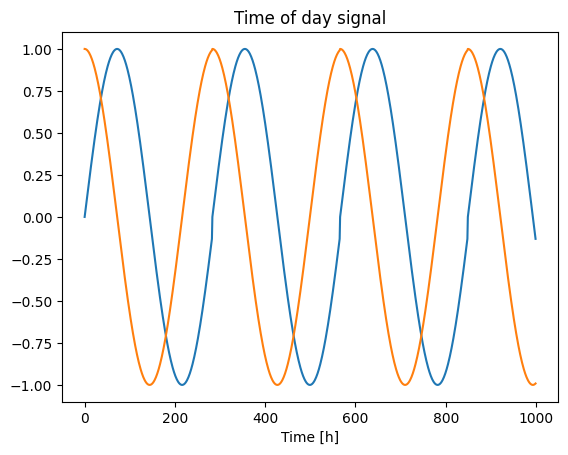

In [39]:
plt.plot(np.array(meteo_data['Day sin'])[:1000])
plt.plot(np.array(meteo_data['Day cos'])[:1000])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [30]:
#meteo_data = meteo_data.drop(['windSpeed', 'windDir'], axis=1)
#meteo_data

In [48]:
def prepare_learning_sets(dataframe,input_sequence_length_min=60,
                          output_sequence_length_min=30,test_size=0.2,
                          sampling_rate_min=5, 
                          out_column='Temperature',
                          return_scaler = True):

    '''
    This routine first splits the dataframe into training and testing, scales all columns, and finally arrange the
    training and testing sets into their final form for training and testing. The final form consists in an array 
    of time series of input_sequence_length_min minutes and corresponding target time series of 
    output_sequence_length_min minutes. 
    '''
    n_input_sequence = input_sequence_length_min//sampling_rate_min
    n_output_sequence = output_sequence_length_min//sampling_rate_min
    n_full_sequence  = n_input_sequence+n_output_sequence
    n_features = dataframe.shape[1]
    X_train = np.empty((0,n_input_sequence,n_features))
    X_test = np.empty((0,n_input_sequence,n_features))
    Y_train = np.empty((0,n_output_sequence,1))
    Y_test = np.empty((0,n_output_sequence,1))
    out_column_index = dataframe.columns.get_loc(out_column)

    for group in np.unique(dataframe['groups']):
        current = dataframe[dataframe.groups==group]
        

        # Split and check that current dataframes have enough samples
        train_df, test_df = train_test_split(current,test_size=test_size,shuffle=False)

        if (train_df.shape[0] < n_full_sequence or test_df.shape[0] < n_full_sequence):
            continue

        
        for col in train_df.columns:
            scaler = MinMaxScaler(feature_range=(-1,1))
            ss = scaler.fit_transform(train_df[col].values.reshape((-1,1)))
            ss = ss.reshape(len(ss)) # Get rid of extra dim
            train_df.loc[:,col] = ss
            train_df.rename(columns={col:"scaled_%s"%col},inplace=True)
        
            if col==out_column:
                out_scaler = scaler
            # Now process the corresponding column from the test dataframe
            ss = scaler.transform(test_df[col].values.reshape((-1,1)))
            ss = ss.reshape(len(ss))
            test_df.loc[:,col] = ss
            test_df.rename(columns={col:"scaled_%s"%col},inplace=True)


        # Fill missing values
        train_df = fill_missing_values(train_df)
        test_df  = fill_missing_values(test_df)
        

        # Now chunk the sets
        x_train, y_train = split_series(train_df.values,n_input_sequence,n_output_sequence,out_column_index=out_column_index)
        x_test,  y_test  = split_series(test_df.values, n_input_sequence,n_output_sequence,out_column_index=out_column_index)
        
        print('x_train',x_train.shape)
        print('y_train',y_train.shape)
        print('x_test',x_test.shape)
        print('y_test',y_test.shape)
        
        
        X_train = np.append(X_train,x_train,axis=0)
        Y_train = np.append(Y_train,y_train,axis=0)
        X_test  = np.append(X_test,x_test,axis=0)
        Y_test  = np.append(Y_test,y_test,axis=0)
    if (return_scaler):
        return(X_train,Y_train,X_test,Y_test,out_scaler)
    else:
        return (X_train,Y_train,X_test,Y_test)

In [49]:
X_train, Y_train, X_test, Y_test,out_scaler =  prepare_learning_sets(meteo_data,input_sequence_length_min=60,
                          output_sequence_length_min=30,test_size=0.2,
                          sampling_rate_min=5, 
                          out_column='Temperature',
                          return_scaler = True)

C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Mary-\anacond

len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209, 6, 1)
x_test (40, 12, 10)
y_test (40, 6, 1)
len 226
len 57
x_train (209, 12, 10)
y_train (209,

C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Mary-\anaconda3\envs\ML\lib\site-packages\sklearn\preprocessing\_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Mary-\anacond

error: (m>k) failed for hidden m: fpcurf0:m=3

In [1]:
#X_train.shape

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[2]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [57]:
def create_lstm_two_layers(n_past,n_features_in,n_future,n_features_out,n_hidden=100):

    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features_in))
    encoder_l1 = tf.keras.layers.LSTM(n_hidden,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(n_hidden, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(n_hidden, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(n_hidden, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features_out))(decoder_l2)
    #
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
    #
    model_e2d2.summary()

    return(model_e2d2)

In [62]:
model_1 = create_lstm_two_layers(X_train.shape[1],X_train.shape[2],Y_train.shape[1],Y_train.shape[2],n_hidden=100)
model_1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12, 4)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 12, 100),    42000       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_9 (LSTM)                  [(None, 100),        80400       ['lstm_8[0][0]']                 
                                 (None, 100),                                                 

Epoch 1/5
25716/25716 [==============================] - 131s 5ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 2/5
25716/25716 [==============================] - 124s 5ms/step - loss: 0.0046 - val_loss: 9.4011e-04
Epoch 3/5
25716/25716 [==============================] - 126s 5ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 4/5
25716/25716 [==============================] - 124s 5ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 5/5
25716/25716 [==============================] - 132s 5ms/step - loss: 0.0044 - val_loss: 0.0012


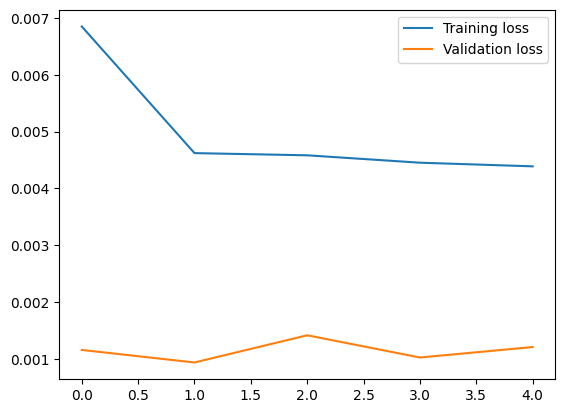

In [63]:
# fit the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()